## Tracking our robot

We own a cheap cleaning robot that drives around in a random fashion. 
Because of the law of large numbers we can assume that if we let the robot clean for a large amount of time it should clean everything, however we usually don't want to wait that long. 
That's why we thought it might be interesting to automatically track where the robot moves.
Then we can plot a heat map of where it spent what amount of time.

### Single Frame

For that we need a video stream and  locate the robot in every frame.
But let's start with a single frame:

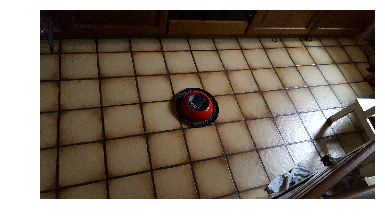

In [1]:
%matplotlib inline
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt
import cv2
import imageio

img = imread('robi.jpg')
plt.axis('off')
plt.imshow(img)

Our robot has a red body which we can use to detect him in the red channel. 
However since white light also has large red values we have to use a little trick.
We subtract the green channel from the red channel.
The red robot does not have much green values so its red values should still be large, but the white spots should now be less red.

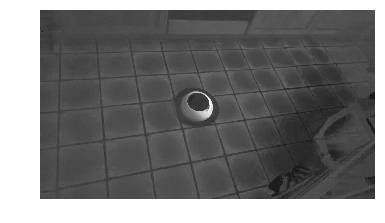

In [2]:
r = np.asarray(img[:, :, 0], dtype=np.float64)
g = np.asarray(img[:, :, 1], dtype=np.float64)
b = np.asarray(img[:, :, 2], dtype=np.float64)

red = r - g

plt.axis('off')
plt.imshow(red, cmap='gray')

Now the robot can be found by simple thresholding in the red channel. We take all robot pixels and compute the means of their x and y coordinates to get a point that we use as center for our bounding box. It may not be the exact center of the robot but the bounding box should include the entire robot.

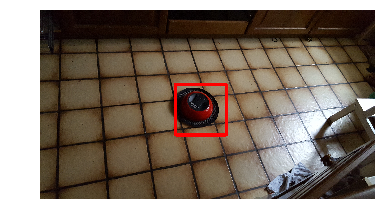

In [3]:
w = 400
h = 400
y = int(np.argwhere(red > 40)[: , 0].mean())
x = int(np.argwhere(red > 40)[: , 1].mean())

img2 = np.copy(img)
cv2.rectangle(img2, (x - w, y - h),(x + w, y + h), (255,0,0), 50)

plt.axis('off')
plt.imshow(img2)

### Video

Let's start by defining a function that applies our computation on a single frame:

In [ ]:
def single_frame(frame, threshold=50):
    r = np.asarray(frame[:, :, 0], dtype=np.float64)
    g = np.asarray(frame[:, :, 1], dtype=np.float64)

    red = r - g
    
    y = int(np.argwhere(red > threshold)[: , 0].mean())
    x = int(np.argwhere(red > threshold)[: , 1].mean())
    
    return x, y

Our next step is to load a video file and apply our single frame function on every frame of the video.
The video has a different resolution than our image before, which is why we change the size of our bounding box.

In [ ]:
vid = imageio.get_reader('virobi.mp4',  'ffmpeg')

N = vid.get_length() - 10
w, h = 150, 150

out = imageio.get_writer('virobi_result.mp4',  'ffmpeg')

for n in range(N):
    frame = vid.get_data(n)
    x, y = single_frame(frame)
    cv2.rectangle(frame,(x - w, y - h),(x + w, y + h), (255,0,0), 10)
    out.append_data(frame)

out.close()

### Optical flow

As a next step we want to compute the optical flow of our video. 
While our first method was just detecting the robot in every frame independent from the other frames,
the optical flow very much depends on a frame's predecessor.

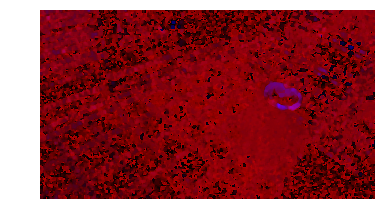

In [4]:
vid = imageio.get_reader('virobi.mp4',  'ffmpeg')

frame1 = vid.get_data(150)
frame2 = vid.get_data(151)

hsv = np.zeros_like(frame1)

prvs = cv2.cvtColor(frame1,cv2.COLOR_RGB2GRAY)
sucs = cv2.cvtColor(frame2,cv2.COLOR_RGB2GRAY)

flow = cv2.calcOpticalFlowFarneback(prvs,sucs, None, 0.5, 3, 15, 3, 5, 1.2, 0)

mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
hsv[...,0] = ang*180/np.pi/2
hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

plt.axis('off')
plt.imshow(hsv)

As you can see there is a lot of movement in the background. 
That's because we filmed this 'by hand' which means this movement is actually the camera moving. 
The movement itself is rather small but the dense optical flow computation can find very small movements.
However the movement of the robot has been found in this frame.
Finally we want to compile a short video of the flow to see how good the changes of directions of the robot are captured.

In [ ]:
vid = imageio.get_reader('virobi.mp4',  'ffmpeg')
out = imageio.get_writer('virobi_flow.mp4',  'ffmpeg')

N = vid.get_length() - 10

for n in range(1, 100):
    frame1 = vid.get_data(n-1)
    frame2 = vid.get_data(n)

    hsv = np.zeros_like(frame1)

    prvs = cv2.cvtColor(frame1,cv2.COLOR_RGB2GRAY)
    sucs = cv2.cvtColor(frame2,cv2.COLOR_RGB2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prvs,sucs, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    
    out.append_data(hsv)

out.close()